In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import cv2
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from ultralytics import YOLO
import glob
import pandas as pd
import shutil

In [2]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype('float32') / 255.
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def display_pairs(images, labels, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - images: An array containing the pair of images.
        - labels: An array containing the corresponding label (0 if both 
            pairs are different, and 1 if both pairs are the same.)
        - correct (optional): An array of boolean values indicating whether 
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(images[:n, 0], images[:n, 1])):
        label = int(labels[:n][i][0])

        text = "Label"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Prediction"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"
            
        ax = plt.subplot(3, n, i + 1)
        ax.text(1, -3 ,f"{text}: {label}", style="italic", bbox={
            "facecolor": color, 
            "pad": 4
        })

        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def plot_history(history):
    """
    Plots the training and validation loss.
    """

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Training and Validation Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


def generate_pairs(images, labels):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    x_pairs = []
    y_pairs = []

    for i in range(len(images)):
        label = labels[i]

        j = np.random.choice(np.where(labels == label)[0])
        x_pairs.append([images[i], images[j]])
        y_pairs.append([1])
        
        k = np.random.choice(np.where(labels != label)[0])
        x_pairs.append([images[i], images[k]])
        y_pairs.append([0])

    indices = np.arange(len(x_pairs))
    np.random.shuffle(indices)
    
    return np.array(x_pairs)[indices], np.array(y_pairs)[indices]

In [3]:
detect_model = YOLO("digit_detection.pt")
class_map_digits = {
    0: 'number',
    1: 'slash'
}

In [54]:
REGION_ROOT = "trainning_siamese"
import os
import glob
import shutil
import pandas as pd

def save_labeled_digits(field="id"):
    digit_dir = os.path.join(REGION_ROOT, f"digits_{field}")
    labeled_dir = os.path.join(REGION_ROOT, f"labeled_digits_{field}")
    os.makedirs(labeled_dir, exist_ok=True)

    # Load labels
    csv_path = "trainning_siamese/crop_labels.csv"
    df = pd.read_csv(csv_path)
    label_dict = dict(zip(df['crop_filename'], df['label']))

    # Get first 500 cropped digit files
    cropped_files = sorted(glob.glob(os.path.join(digit_dir, "*.jpg")))
    print(f"Processing {len(cropped_files)} files from {digit_dir}")

    for file in cropped_files:
        fname = os.path.basename(file)  # e.g., dob_00001_03.jpg
        key = '_'.join(fname.split('_')[:2]) + '.jpg'  # → dob_00001.jpg
        index = int(fname.split('_')[-1].split('.')[0])  # → 03
        # Check if the key exists in the label dictionary

        if key not in label_dict:
            print(f"Warning: {key} not found in label dictionary. Skipping file {file}.")
            continue

        label_str = label_dict[key]
        label_str = label_dict[key].replace("/", "")
        if index >= len(label_str):
            continue

        char = label_str[index]
        if not char.isdigit():
            continue  # Skip slashes

        out_folder = os.path.join(labeled_dir, char)
        os.makedirs(out_folder, exist_ok=True)

        shutil.copy(file, os.path.join(out_folder, fname))



def cropped_digits(img_path, field):
    if field == "id":
        output_dir = os.path.join(REGION_ROOT, "digits_id")
    else:
        output_dir = os.path.join(REGION_ROOT, "digits_dob")
    fname = os.path.basename(img_path)
    base, ext = os.path.splitext(fname)
    
    # 1) Run inference
    res = detect_model(img_path, conf=0.75, verbose=False, save=True, save_txt=True)[0]
    boxes   = res.boxes.xyxy.cpu().numpy()
    classes = res.boxes.cls.cpu().numpy().astype(int)
    img = cv2.imread(img_path)
 
    bboxes = []
    for cls_id, (x1, y1, x2, y2) in zip(classes, boxes):
        if cls_id == 0:
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            if x2 - x1 > 2 and y2 - y1 > 2:  # filter tiny boxes
                bboxes.append((x1, y1, x2, y2))

    if not bboxes:
        print(f"[{fname}] No class-0 digits found.")
        return
    if len(bboxes) != 12:
        print(f"⚠️ {fname}: {len(bboxes)} digits found (expected 8)")
        return

    # 4) Sort left to right
    bboxes.sort(key=lambda box: box[0])

    # 5) Crop and save
    os.makedirs(output_dir, exist_ok=True)

    for i, (x1, y1, x2, y2) in enumerate(bboxes):
        crop = img[y1:y2, x1:x2]
        crop = cv2.resize(crop, (28, 28))
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        out_name = f"{base}_{i:02d}.jpg"
        out_path = os.path.join(output_dir, out_name)
        cv2.imwrite(out_path, crop)

img_paths = sorted(glob.glob("trainning_siamese/crops_id/*.jpg"))
for img_path in img_paths:
    cropped_digits(img_path, "id")

save_labeled_digits("id")

Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs

In [73]:
REGION_ROOT = "cropped_id_train_1"
def cropped_digits(img_path, field):
    if field == "dob":
        output_dir = os.path.join(REGION_ROOT, "digits_dob")
    else:
        output_dir = os.path.join(REGION_ROOT, "digits_id")
    fname = os.path.basename(img_path)
    base, ext = os.path.splitext(fname)
    
    # 1) Run inference
    res = detect_model(img_path, conf=0.86, verbose=False, save=True, save_txt=True)[0]
    boxes   = res.boxes.xyxy.cpu().numpy()
    classes = res.boxes.cls.cpu().numpy().astype(int)
    img = cv2.imread(img_path)
 
    bboxes = []
    for cls_id, (x1, y1, x2, y2) in zip(classes, boxes):
        if cls_id == 0:
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            if x2 - x1 > 2 and y2 - y1 > 2:  # filter tiny boxes
                bboxes.append((x1, y1, x2, y2))

    if not bboxes:
        print(f"[{fname}] No class-0 digits found.")
        return
    if len(bboxes) != 12:
        print(f"⚠️ {fname}: {len(bboxes)} digits found (expected 8)")

    # 4) Sort left to right
    bboxes.sort(key=lambda box: box[0])

    # 5) Crop and save
    os.makedirs(output_dir, exist_ok=True)
    for i, (x1, y1, x2, y2) in enumerate(bboxes):
        crop = img[y1:y2, x1:x2]
        crop = cv2.resize(crop, (28, 28))
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        out_name = f"{base}_{i:02d}.jpg"
        out_path = os.path.join(output_dir, out_name)
        cv2.imwrite(out_path, crop)

img_paths = sorted(glob.glob("cropped_id_train_1/*.jpg"))
for img_path in img_paths:
    cropped_digits(img_path, "id")



Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2245 labels saved to runs/detect/predict12/labels
Results saved to runs

In [74]:
def save_labeled_digits(field="id"):
    digit_dir = os.path.join(REGION_ROOT, f"digits_{field}")
    labeled_dir = os.path.join(REGION_ROOT, f"labeled_digits_{field}")
    os.makedirs(labeled_dir, exist_ok=True)

    # Load labels
    csv_path = "gt_2s.csv"
    df = pd.read_csv(csv_path)
    label_dict = dict(zip(df['filename'], df['id']))

    # Get first 500 cropped digit files
    cropped_files = sorted(glob.glob(os.path.join(digit_dir, "*.jpg")))
    
    for file in cropped_files:

        fname = os.path.basename(file)  # e.g., dob_00001_03.jpg
        key = '_'.join(fname.split('_')[:1])+'.jpg'   # → dob_00001.jpg
        index = int(fname.split('_')[-1].split('.')[0])  # → 03

        # Check if the key exists in the label dictionary

        if key not in label_dict:
            print(f"Warning: {key} not found in label dictionary. Skipping file {file}.")
            continue

        label_str = label_dict[key]
        label_str = label_dict[key].replace("/", "")
        if index >= len(label_str):
            continue

        char = label_str[index]
        if not char.isdigit():
            continue  # Skip slashes

        out_folder = os.path.join(labeled_dir, char)
        os.makedirs(out_folder, exist_ok=True)

        shutil.copy(file, os.path.join(out_folder, fname))

save_labeled_digits("id")



In [63]:
REGION_ROOT = "template"
import os
import glob
import shutil
import pandas as pd

def save_labeled_digits(field="id"):
    digit_dir = os.path.join(REGION_ROOT, f"digits_{field}")
    labeled_dir = os.path.join(REGION_ROOT, f"labeled_digits_{field}")
    os.makedirs(labeled_dir, exist_ok=True)

    # Load labels
    csv_path = "template/crop_labels.csv"
    df = pd.read_csv(csv_path)
    label_dict = dict(zip(df['crop_filename'], df['label']))
    print("→ total unique keys in labels:", len(label_dict))

    
    cropped_files = sorted(glob.glob(os.path.join(digit_dir, "*.jpg")))
    print(f"Processing {len(cropped_files)} files from {digit_dir}")

    for file in cropped_files:       

        fname = os.path.basename(file)  # e.g., dob_00001_03.jpg
        key = '_'.join(fname.split('_')[:2]) + '.jpg'  # → dob_00001.jpg
        print(f"Processing file: {file}, key: {key}")
        index = int(fname.split('_')[-1].split('.')[0])  # → 03
        # Check if the key exists in the label dictionary

        if key not in label_dict:
            print(f"Warning: {key} not found in label dictionary. Skipping file {file}.")
            continue

        label_str = label_dict[key]
        label_str = label_dict[key].replace("/", "")
        if index >= len(label_str):
            continue

        char = label_str[index]
        if not char.isdigit():
            continue  # Skip slashes

        out_folder = os.path.join(labeled_dir, char)
        os.makedirs(out_folder, exist_ok=True)

        shutil.copy(file, os.path.join(out_folder, fname))



def cropped_digits(img_path, field):
    if field == "id":
        output_dir = os.path.join(REGION_ROOT, "digits_id")
    else:
        output_dir = os.path.join(REGION_ROOT, "digits_dob")
    fname = os.path.basename(img_path)
    base, ext = os.path.splitext(fname)
    
    # 1) Run inference
    res = detect_model(img_path, conf=0.7, verbose=False, save=True, save_txt=True)[0]
    boxes   = res.boxes.xyxy.cpu().numpy()
    classes = res.boxes.cls.cpu().numpy().astype(int)
    img = cv2.imread(img_path)
 
    bboxes = []
    for cls_id, (x1, y1, x2, y2) in zip(classes, boxes):
        if cls_id == 0:
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            if x2 - x1 > 2 and y2 - y1 > 2:  # filter tiny boxes
                bboxes.append((x1, y1, x2, y2))

    if not bboxes:
        print(f"[{fname}] No class-0 digits found.")
        return
    if len(bboxes) != 12:
        print(f"⚠️ {fname}: {len(bboxes)} digits found (expected 8)")

    # 4) Sort left to right
    bboxes.sort(key=lambda box: box[0])

    # 5) Crop and save
    os.makedirs(output_dir, exist_ok=True)
    for i, (x1, y1, x2, y2) in enumerate(bboxes):
        crop = img[y1:y2, x1:x2]
        crop = cv2.resize(crop, (28, 28))
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        out_name = f"{base}_{i:02d}.jpg"
        out_path = os.path.join(output_dir, out_name)
        cv2.imwrite(out_path, crop)
img_paths = sorted(glob.glob("template/crops_id/*.jpg"))
for img_path in img_paths:
    cropped_digits(img_path, "id")

save_labeled_digits("id")



Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
Results saved to runs/detect/predict12
2000 labels saved to runs/detect/predict12/labels
→ total unique keys in labels: 20
Processing 120 files from template/digits_id
Processing file: template/digit

In [245]:
# Load full training data (we'll split validation from it)
full_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "trainning_siamese/labeled_digits_dob",
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',      # use 'rgb' if your model expects 3 channels
    image_size=(28, 28),
    shuffle=True,
    batch_size=None              # unbatched: returns (image, label) tuples
)

# Load test set
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cropped_dob_valid_1/labeled_digits_dob",
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=(28, 28),
    shuffle=False,
    batch_size=None
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cropped_dob_train/labeled_digits_dob",
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=(28, 28),
    shuffle=False,
    batch_size=None
)
template_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "template/labeled_digits_dob",
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=(28, 28),
    shuffle=False,
    batch_size=None
)
def dataset_to_numpy(ds):
    images, labels = [], []
    for img, label in ds:
        images.append(img.numpy())
        labels.append(label.numpy())
    return np.stack(images), np.array(labels)

x_train, y_train = dataset_to_numpy(full_train_ds)
x_test, y_test = dataset_to_numpy(test_ds)
x_val, y_val = dataset_to_numpy(valid_ds)
x_temp, y_temp = dataset_to_numpy(template_ds)

# VALIDATION_SIZE = int(len(x_train) * 0.2)

# x_val = x_train[:VALIDATION_SIZE]
# y_val = y_train[:VALIDATION_SIZE]

# x_train = x_train[VALIDATION_SIZE:]
# y_train = y_train[VALIDATION_SIZE:]

x_train = preprocess(x_train)
x_val = preprocess(x_val)
x_test = preprocess(x_test)
x_temp = preprocess(x_temp)

print(f"Train: {len(x_train)}")
print(f"Validation: {len(x_val)}")
print(f"Test: {len(x_test)}")
print(f"Template: {len(x_temp)}")

Found 7064 files belonging to 10 classes.
Found 480 files belonging to 10 classes.
Found 1480 files belonging to 10 classes.
Found 104 files belonging to 10 classes.
Train: 7064
Validation: 480
Test: 1480
Template: 104


In [200]:
x_pairs_train, y_pairs_train = generate_pairs(x_train, y_train)
x_pairs_val, y_pairs_val = generate_pairs(x_val, y_val)
x_pairs_test, y_pairs_test = generate_pairs(x_test, y_test)

In [220]:
x_pairs_temp, y_pairs_temp = generate_pairs(x_temp, y_temp)

In [183]:
np.unique(y_pairs_train, return_counts=True)

(array([0, 1]), array([7064, 7064]))

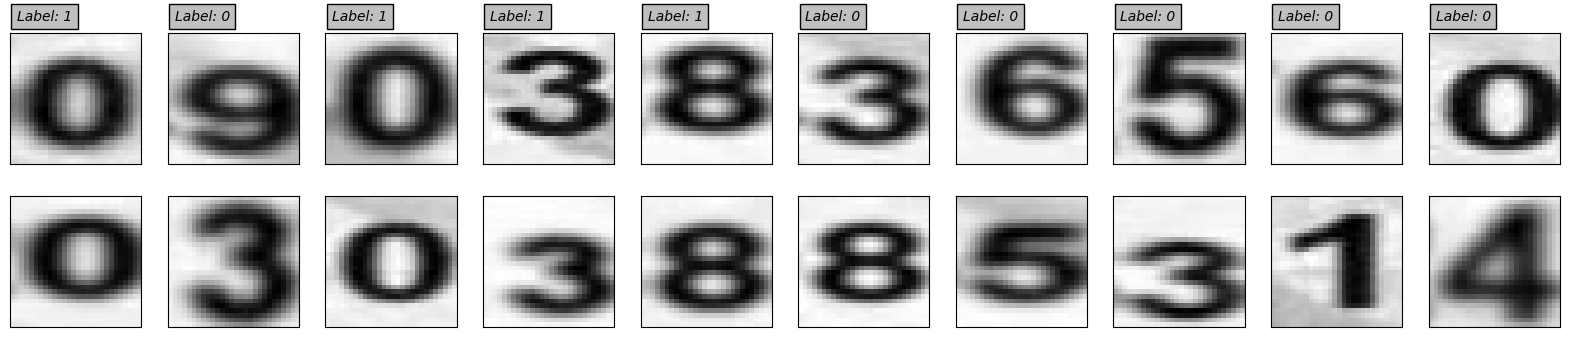

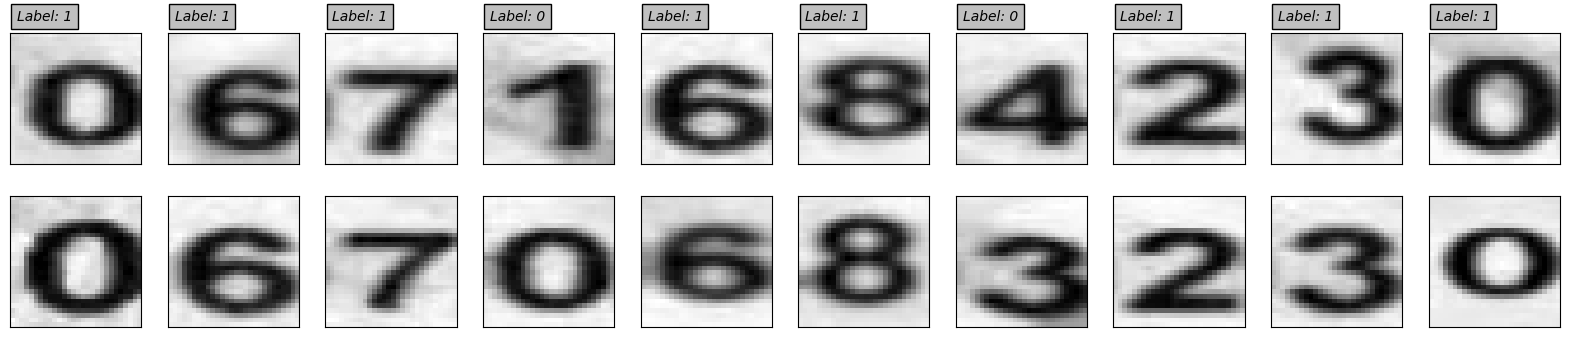

In [80]:
display_pairs(x_pairs_train, y_pairs_train)
display_pairs(x_pairs_val, y_pairs_val)


In [140]:
def norm(features):
    """
    Computes the euclidean norm of the two feature vectors generated
    by the twins of the Siamese network.
    """
    a, b = features
    a_norm = tf.nn.l2_normalize(a, axis=1)
    b_norm = tf.nn.l2_normalize(b, axis=1)
    cos_sim = tf.reduce_sum(a_norm * b_norm, axis=1, keepdims=True)
    return 1.0 - cos_sim   
 

def accuracy(y_true, y_pred):
    """
    Computes the accuracy of the predictions. 
    """

    # Notice that `y_true` is 0 whenever two images are not the same and 1 
    # otherwise, but `y_pred` is the opposite. The closer `y_pred` is to 0, 
    # the shorter the distance between both images, therefore the more likely 
    # it is that they are the same image. To correctly compute the accuracy we
    # need to substract `y_pred` from 1 so both vectors are comparable.
    return metrics.binary_accuracy(y_true, 1 - y_pred)


def contrastive_loss(y_true, y_pred):
    """
    Computes the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping," 2005.
    """

    # The original formula proposed by Yann LeCunn et al. assumes that Y is 0
    # if both images are similar and 1 otherwise. Our implementation (where Y is
    # `y_true`) is the opposite, hence the modification to the formula below.
    margin = 1.0
    y_true = tf.cast(y_true, y_pred.dtype)
    pos = (y_true / 2) * K.square(y_pred)
    neg = ((1 - y_true) / 2) * K.square(K.maximum(0.0, margin - y_pred))
    return pos + neg

In [144]:
def siamese_twin():
    """
    Creates the subnetwork that represents each one of the twins of the
    Siamese network.
    """

    inputs = layers.Input((28, 28, 1))

    x = layers.Conv2D(128, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling2D()(x)

    # We don't want any activation function on the final layer. This layer
    # will contain the embedding for the input image.

    outputs = layers.Dense(128, activation=None)(x)

    return Model(inputs, outputs, name = "embedder")
 
 
def siamese_network():
    """
    Creates the Siamese Network model.
    """

    input1 = layers.Input(shape=(28, 28, 1))
    input2 = layers.Input(shape=(28, 28, 1))

    twin = siamese_twin()

    # We can use a Lambda layer to compute the euclidean distance of the
    # embeddings from each image.
    distance = layers.Lambda(norm)([
        twin(input1), 
        twin(input2)
    ])

    # Our model has two inputs: the first input is for the anchor image and
    # the second input is for the second image of the pair. The output of the
    # model is the euclidean distance between the embeddings from each image.
    return Model(inputs=[input1, input2], outputs=distance)     

In [145]:
lr0 = 0.0005  # your initial learning rate

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=lr0,
    decay_steps=1000,
    alpha=0.1  # final_lr = alpha * initial_lr
)
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='best_siamese_cosine_model.h5',
    monitor='val_loss',         # or 'val_accuracy' if using accuracy
    save_best_only=True,        # Only save the best version
    save_weights_only=False,    # Save entire model (architecture + weights)
    verbose=1
)
model = siamese_network()
model.compile(
    loss=contrastive_loss, 
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), 
    metrics=[accuracy]
)

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_29 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 embedder (Functional)       (None, 128)                  312960    ['input_28[0][0]',            
                                                                     'input_29[0][0]']            
                                                                                                  
 lambda_9 (Lambda)           (None, 1)                    0         ['embedder[0][0]',     

In [164]:
history = model.fit(
    x=[x_pairs_train[:, 0], x_pairs_train[:, 1]], 
    y=y_pairs_train[:], 
    validation_data=([x_pairs_val[:, 0], x_pairs_val[:, 1]], y_pairs_val[:]),
	batch_size=64,
	epochs=3,
    callbacks=[checkpoint_cb]
)

Epoch 1/3
221/221 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9833
Epoch 1: val_loss did not improve from 0.00662
221/221 [==============================] - 37s 169ms/step - loss: 0.0090 - accuracy: 0.9833 - val_loss: 0.0074 - val_accuracy: 0.9896
Epoch 2/3
221/221 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9844
Epoch 2: val_loss did not improve from 0.00662
221/221 [==============================] - 38s 174ms/step - loss: 0.0082 - accuracy: 0.9844 - val_loss: 0.0083 - val_accuracy: 0.9885
Epoch 3/3
221/221 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9875
Epoch 3: val_loss did not improve from 0.00662
221/221 [==============================] - 35s 157ms/step - loss: 0.0067 - accuracy: 0.9875 - val_loss: 0.0075 - val_accuracy: 0.9896


In [175]:
model.load_weights('best_siamese_cosine_model.keras')

93/93 [==============================] - 2s 27ms/step


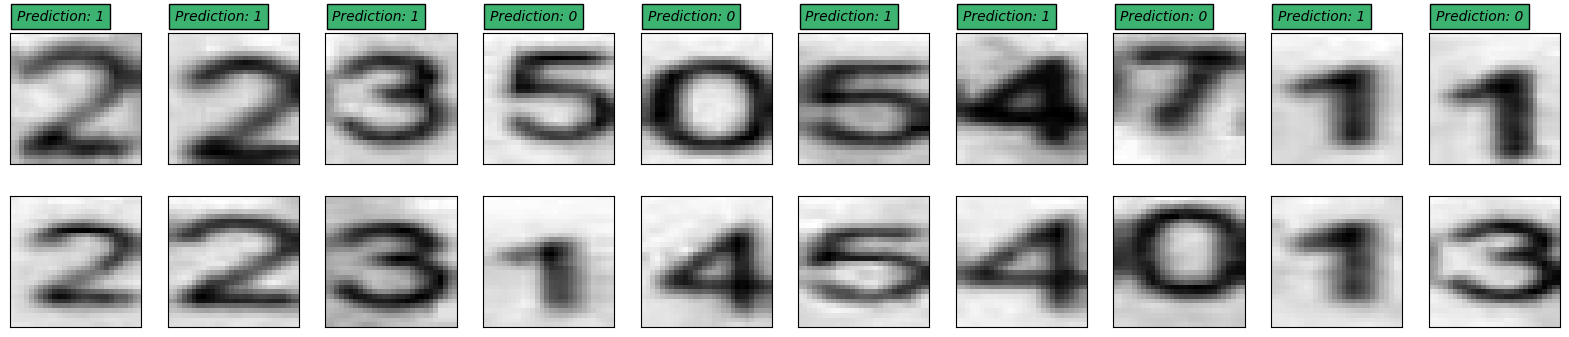


Accuracy: 0.9949324131011963


In [202]:
y_pred = model.predict([x_pairs_test[:, 0], x_pairs_test[:, 1]])

predictions = np.round(1 - y_pred)  # Convert distances to binary predictions

display_pairs(x_pairs_test, predictions, predictions == y_pairs_test)

accuracy = metrics.BinaryAccuracy()
accuracy.update_state(y_pairs_test, predictions)
print(f"\nAccuracy: {accuracy.result().numpy()}")

In [246]:
embedder: Model = model.get_layer("embedder")
E_templates = embedder.predict(x_temp, batch_size=64)  # → (M,128)
E_tests     = embedder.predict(x_test,    batch_size=64) 

E_templates_norm = E_templates / np.linalg.norm(E_templates, axis=1, keepdims=True)
E_tests_norm     = E_tests     / np.linalg.norm(E_tests,     axis=1, keepdims=True)
# sims_matrix[i,j] = dot(E_tests_norm[i], E_templates_norm[j])
sims_matrix = E_tests_norm @ E_templates_norm.T

24/24 [==============================] - 0s 16ms/step


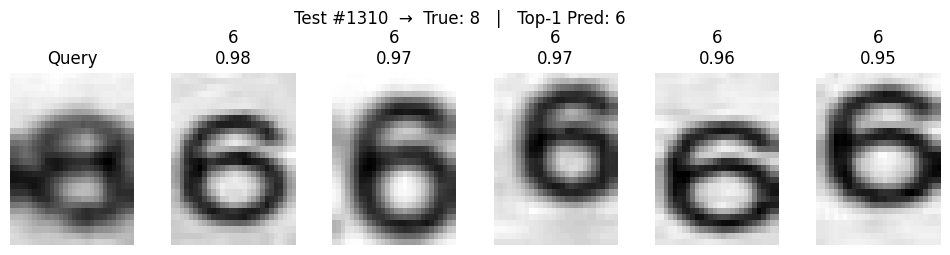

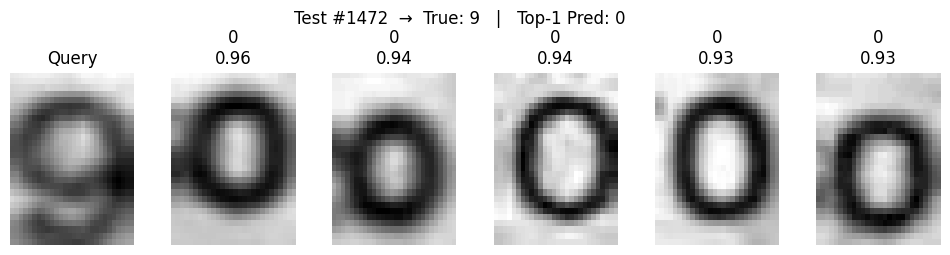

In [247]:
import numpy as np
import matplotlib.pyplot as plt
import math

# recompute wrong indices if you need to
best_inds   = np.argmax(sims_matrix, axis=1)
pred_labels = [y_temp[idx] for idx in best_inds]
wrong_inds  = [i for i, lbl in enumerate(pred_labels) if str(lbl) != str(y_test[i])]

for idx in wrong_inds:
    # get the 5 highest‐sim templates
    sims      = sims_matrix[idx]
    top5      = np.argsort(sims)[::-1][:5]
    true_lbl  = y_test[idx]
    pred_lbl  = pred_labels[idx]

    # make a 1×6 figure
    fig, axes = plt.subplots(1, 6, figsize=(12, 2.5))
    fig.suptitle(f"Test #{idx}  →  True: {true_lbl}   |   Top-1 Pred: {pred_lbl}", y=1.05)

    # 1) plot the query
    axes[0].imshow(x_test[idx].squeeze(), cmap='gray', aspect='auto')
    axes[0].set_title("Query")
    axes[0].axis('off')

    # 2) plot the 5 templates
    for j, tpl_idx in enumerate(top5, start=1):
        axes[j].imshow(x_temp[tpl_idx].squeeze(), cmap='gray', aspect='auto')
        score = sims[tpl_idx]
        axes[j].set_title(f"{y_temp[tpl_idx]}\n{score:.2f}")
        axes[j].axis('off')

    # tighten and show
    plt.subplots_adjust(wspace=0.3, top=0.8)
    plt.show()


In [248]:
from collections import defaultdict
import os
val_image_paths = sorted(glob.glob("cropped_id_train_1/labeled_digits_id/*/*.jpg"))
# Step 1: Group predictions by base filename
grouped_preds = defaultdict(list)

for path, pred_char in zip(val_image_paths, pred_labels):
    fname = os.path.basename(path)                  # e.g., dob_00001_03.jpg
    key = '_'.join(fname.split('_')[:1])+'.jpg'   # → dob_00001.jpg
    grouped_preds[key].append((path, pred_char))

# Step 2: Assemble final predictions by sorting crop indices

final_rows = []

for key in sorted(grouped_preds.keys()):
    crops = grouped_preds[key]
    sorted_crops = sorted(
        crops,
        key=lambda x: int(os.path.splitext(x[0])[0].split('_')[-1])
    )
    # ensure each pred_char is a string
    predicted_str = ''.join(str(char) for _, char in sorted_crops)
    final_rows.append((key, predicted_str))


import pandas as pd

df = pd.DataFrame(final_rows, columns=["filename", "label"])
df.to_csv("id_predictions.csv", index=False)
print("✅ Saved to id_predictions.csv")

✅ Saved to id_predictions.csv


In [112]:
# Load predicted results
df_pred = pd.read_csv("id_predictions.csv", dtype =str)
df_gt = pd.read_csv("gt_2s.csv",dtype=str)

# Merge with ground truth
df_merged = pd.merge(df_pred, df_gt, on="filename", how="inner")

# Format prediction as DD/MM/YYYY (add slashes)
df_merged["formatted_predicted_label"] = df_merged["label"]

# Now compare directly to ground truth label
correct = df_merged["formatted_predicted_label"] == df_merged["id"]
accuracy = correct.mean()

print(f"✅ Accuracy: {accuracy * 100:.2f}% ({correct.sum()}/{len(df_merged)})")


✅ Accuracy: 100.00% (185/185)


In [113]:
model.save_weights('best_siamese_cosine_model_id.keras')

In [249]:
from collections import defaultdict
import os
val_image_paths = sorted(glob.glob("cropped_dob_train/labeled_digits_dob/*/*.jpg"))
# Step 1: Group predictions by base filename
grouped_preds = defaultdict(list)

for path, pred_char in zip(val_image_paths, pred_labels):
    fname = os.path.basename(path)                  # e.g., dob_00001_03.jpg
    key = '_'.join(fname.split('_')[:1])+'.jpg'   # → dob_00001.jpg
    grouped_preds[key].append((path, pred_char))

# Step 2: Assemble final predictions by sorting crop indices

final_rows = []

for key in sorted(grouped_preds.keys()):
    crops = grouped_preds[key]
    sorted_crops = sorted(
        crops,
        key=lambda x: int(os.path.splitext(x[0])[0].split('_')[-1])
    )
    # ensure each pred_char is a string
    predicted_str = ''.join(str(char) for _, char in sorted_crops)
    final_rows.append((key, predicted_str))


import pandas as pd

df = pd.DataFrame(final_rows, columns=["filename", "label"])
df.to_csv("dob_predictions.csv", index=False)
print("✅ Saved to dob_predictions.csv")

✅ Saved to dob_predictions.csv


In [250]:
# Load predicted results
df_pred = pd.read_csv("dob_predictions.csv", dtype =str)
df_gt = pd.read_csv("gt_2s.csv",dtype=str)

# Merge with ground truth
df_merged = pd.merge(df_pred, df_gt, on="filename", how="inner")

# Format prediction as DD/MM/YYYY (add slashes)
df_merged["formatted_predicted_label"] = df_merged["label"].apply(
    lambda s: f"{s[:2]}/{s[2:4]}/{s[4:]}" if len(str(s)) == 8 else str(s)
)

# Now compare directly to ground truth label
correct = df_merged["formatted_predicted_label"] == df_merged["dob"]
accuracy = correct.mean()

print(f"✅ Accuracy: {accuracy * 100:.2f}% ({correct.sum()}/{len(df_merged)})")


✅ Accuracy: 98.92% (183/185)
